# Autoencoder Experiment 2
-------------------------------------------

### This is similar to the Udacity autoencoder model but we'll be using Keras intead of tensorflow
### We'll use Convolutional network in this experiment

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


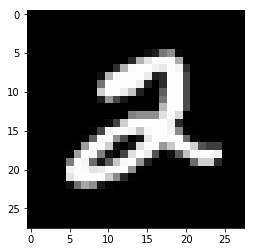

In [3]:
# plot example image
img = mnist.train.images[5]
plt.imshow(img.reshape((28,28)), cmap='Greys_r')

In [32]:
print(mnist.train.images.shape)
print(mnist.train.labels.shape)
# we need to reshape the input to be 28x28
_inputs = mnist.train.images.reshape((-1, 28,28,1))
_targets = mnist.train.images
print(_inputs.shape)

(60000, 784)
(60000,)
(60000, 28, 28, 1)


### We'll need flatten the images to 784 length vectors (images are 28x28), then we'll have a simple encoder/decode with one hidden layer.
#### Hold on... the images in this set are already flattened and normalized, i.e. values are between 0 and 1

In [20]:
def resize_nearest_neighbor(input_tensor, ref_shape): # resizes input tensor to ref_shape 
    return tf.image.resize_nearest_neighbor(input_tensor, ref_shape)


In [45]:
from keras.models import Model
from keras.layers import Input, Activation, Lambda, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

# encoder
encoder_inputs = Input(shape=(28,28,1))

conv_1    = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same')(encoder_inputs)
maxpool_1 = MaxPooling2D(pool_size=(2,2), padding='same')(conv_1)
conv_2    = Conv2D(8, kernel_size=(3,3), activation='relu', padding='same')(maxpool_1)
maxpool_2 = MaxPooling2D(pool_size=(2,2), padding='same')(conv_2)
dropout_1 = Dropout(0.25)(maxpool_2)
conv_3    = Conv2D(8, kernel_size=(3,3), activation='relu', padding='same')(dropout_1)
maxpool_3 = MaxPooling2D(pool_size=(2,2), padding='same')(conv_3)
_encoded  = Dropout(0.25)(maxpool_3)
# Now 4x4x8

# decodor
upsample_1 = Lambda(resize_nearest_neighbor, arguments={'ref_shape':(7,7)})(_encoded)
conv_4     = Conv2D(8, kernel_size=(3,3), activation='relu', padding='same')(upsample_1)
upsample_2 = Lambda(resize_nearest_neighbor, arguments={'ref_shape':(14,14)})(conv_4)
conv_5     = Conv2D(8, kernel_size=(3,3), activation='relu', padding='same')(upsample_2)
upsample_3 = Lambda(resize_nearest_neighbor, arguments={'ref_shape':(28,28)})(conv_5)
conv_6     = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same')(upsample_3)
_decoded   = Conv2D(1, kernel_size=(3,3), padding='same')(conv_6)
_flattened = Flatten()(_decoded)
# Now 28x28x1
_output = Dense(784, name='output', activation='sigmoid')(_flattened)

model = Model(encoder_inputs, _output)
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 7, 7, 8)           584       
__________

In [46]:
# training time
epochs = 10

model.fit(_inputs, _targets, epochs=epochs, batch_size=200, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 72s - loss: 0.0641 - acc: 0.0088      

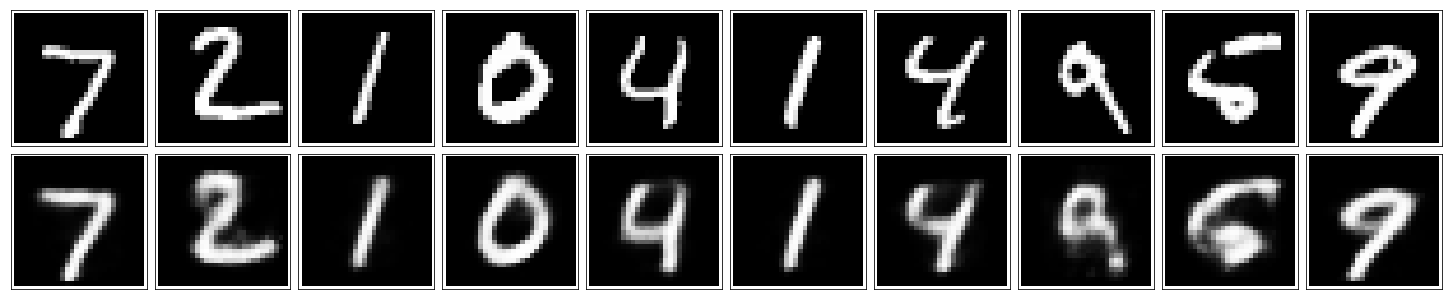

In [47]:
# checking results

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[0:10]
in_imgs = in_imgs.reshape((-1, 28,28,1))
predict_imgs = model.predict(in_imgs, 10)

for images, row in zip([in_imgs, predict_imgs], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape(28, 28), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

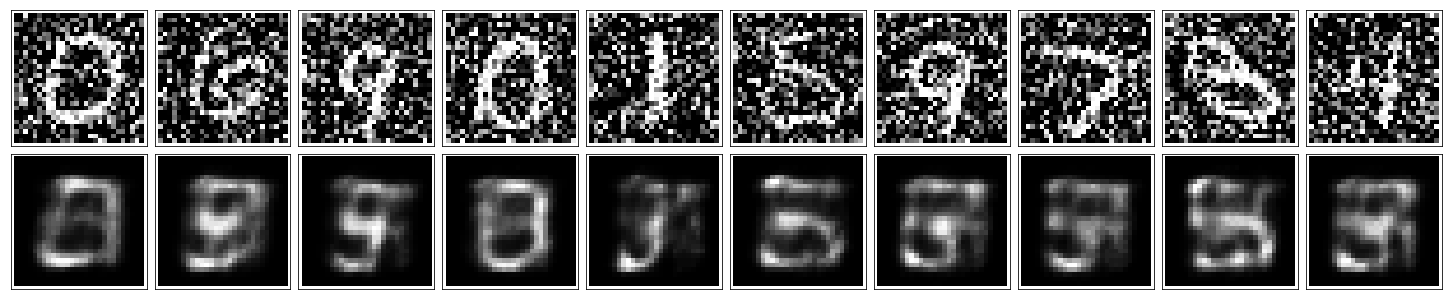

In [48]:
# checking noisy images

noise_factor = 0.5
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[10:20]
in_imgs = in_imgs.reshape((-1, 28,28,1))

noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

predict_imgs = model.predict(noisy_imgs, 10)

for images, row in zip([noisy_imgs, predict_imgs], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape(28, 28), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [50]:
# generate noisy images 

# Add random noise to the input images
noisy_inputs = _inputs + noise_factor * np.random.randn(*_inputs.shape)
# Clip the images to be between 0 and 1
noisy_inputs = np.clip(noisy_inputs, 0., 1.)
noisy_inputs = noisy_inputs.reshape((-1, 28,28,1))

In [51]:
# construct a model for processing noisy images
model2 = Model(encoder_inputs, _output)
model2.compile(loss='mean_squared_error', optimizer='Adam', metrics=['accuracy'])
model2.summary()
epochs = 10
batch_size = 200

# train
model2.fit(noisy_inputs, _targets, epochs=epochs, batch_size=batch_size, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 7, 7, 8)           584       
__________

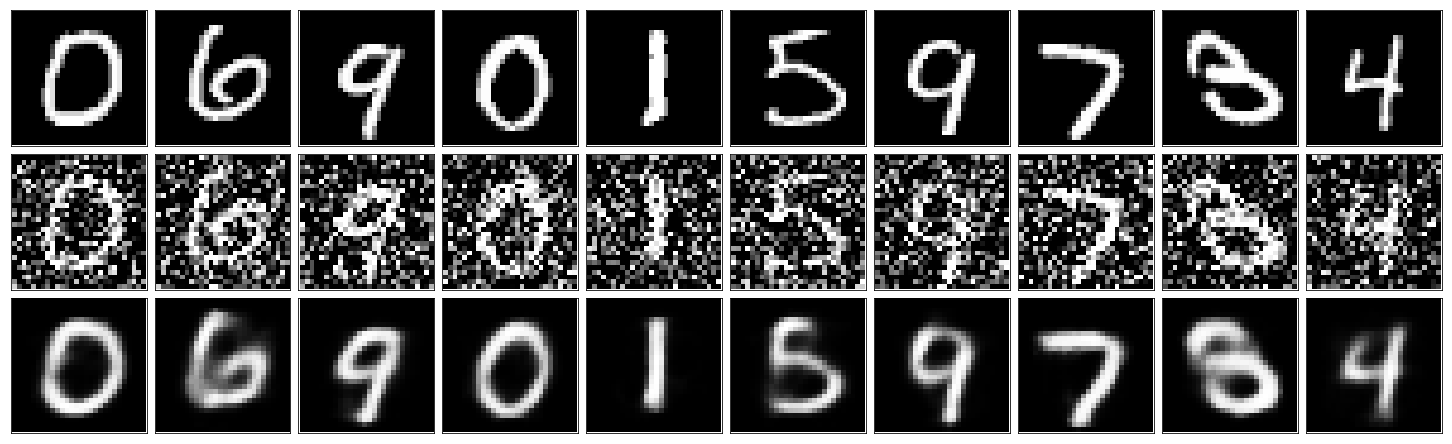

In [52]:
# checking noisy images again with model2
# we'll show the orignal, the noisy, and the de-noised images

noise_factor = 0.5
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,6))
in_imgs = mnist.test.images[10:20]
in_imgs = in_imgs.reshape((-1, 28,28,1))

noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

predict_imgs = model2.predict(noisy_imgs, 10)

for images, row in zip([in_imgs, noisy_imgs, predict_imgs], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape(28, 28), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)